# Read Prepossessed Data and Embeding

In [19]:
import pickle as pkl
import torch
def read_data(filepath):
    
    processed_snli_data_train = pkl.load(open(filepath+"processed_snli_data_train.p", "rb"))
    processed_snli_data_val = pkl.load(open(filepath+"processed_snli_data_val.p", "rb"))
    loaded_embeddings_ft = pkl.load(open(filepath+"loaded_embeddings_ft.p", "rb"))
    
    return processed_snli_data_train, processed_snli_data_val, loaded_embeddings_ft

In [20]:
processed_snli_data_train, processed_snli_data_val, loaded_embeddings_ft=read_data("./data/")

# Import Dataloader 

In [11]:
from SNLI_dataset_loader import SNLI_Dataset, SNLI_collate_func

# Import RNN and CNN models

In [16]:
from models.CNN import CNN 
from models.RNN import RNN

# Test Model function

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [23]:
import torch.nn.functional as F 
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for sentence_1, length_1, sentence_2, length_2, labels in loader:
        sentence_1_batch, length_1_batch, sentence_2_batch, length_2_batch, labels =\
        sentence_1.to(device), length_1.to(device), sentence_2.to(device), length_2.to(device), labels.to(device)
        
        outputs = F.softmax(model(sentence_1_batch, length_1_batch, sentence_2_batch, length_2_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]

        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)


# Train Model function

In [32]:
import tqdm
import pickle as pk


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def train_model(model, learning_rate, num_epochs, filename):

    print("Number of trainable parameters:{}".format(count_parameters(model)))

    
    Loss_list = []
    train_acc = []
    val_acc = []
    # Criterion and Optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    model.to(device)
#     criterion=criterion.to(device)
    
    # Train the model
    total_step = len(train_loader)

    for epoch in tqdm.trange(num_epochs):
        for i, (sentence_1, length_1, sentence_2, length_2, labels) in enumerate(train_loader):
            sentence_1_batch, length_1_batch, sentence_2_batch, length_2_batch, labels =\
        sentence_1.to(device), length_1.to(device), sentence_2.to(device), length_2.to(device), labels.to(device)
            
            model.train()
            optimizer.zero_grad()
            # Forward pass
            
            outputs = model(sentence_1_batch, length_1_batch, sentence_2_batch, length_2_batch)
            
            loss = criterion(outputs, labels)
            Loss_list.append(loss)
            # Backward and optimize
            loss.backward()
            optimizer.step()
            # validate every 100 iterations
            if i > 0 and i % 100 == 0:
                # validate
                train_acc.append(test_model(train_loader, model))
                val_acc.append(test_model(val_loader, model))
                print('Epoch: [{}/{}], Step: [{}/{}], Train Loss: {}, Validation Acc: {}'.format(
                           epoch+1, num_epochs, i+1, len(train_loader), Loss_list[-1], val_acc[-1]))
    
    print("Last model's validation Accuracy:{}".format(val_acc[-1]))
    
    
    
    
#     plt.figure(figsize=(12,20))
#     plt.subplot(2, 1, 1)
#     plt.xlabel("Number of iterations")
#     plt.ylabel("CrossEntropyLoss")
#     #plt.ylim(50, 90)
#     plt.plot(Loss_list)
    
    
#     plt.subplot(2, 1, 2)
#     plt.plot(train_acc, color='b', label='Train Accuracy')
#     plt.plot(val_acc, color='r', label='Val Accuracy')
#     plt.xlabel("Number of 100 times iterations")
#     plt.ylabel("Train&Val Accuracy")
#     plt.legend(loc='best')
#     plt.show()
    
    pk.dump(val_acc, open('./val_acc/'+filename+".p", 'wb'))
    pk.dump(train_acc, open('./train_acc/'+filename+".p", 'wb'))
    pk.dump(Loss_list, open('./Loss/'+filename+".p", 'wb'))
    
    torch.save(model.state_dict(), "./model_trained/"+filename+".pt")

# Create training and validation dataset

In [8]:
# Build train, valid and test dataloaders
import numpy as np

MAX_WORD_LENGTH_1=int (np.percentile([len(instance[0]) for instance in processed_snli_data_train], 99))
MAX_WORD_LENGTH_2=int (np.percentile([len(instance[1]) for instance in processed_snli_data_val], 99))

BATCH_SIZE = 64

train_dataset = SNLI_Dataset(processed_snli_data_train)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=SNLI_collate_func,
                                           shuffle=True)

val_dataset = SNLI_Dataset(processed_snli_data_val)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=SNLI_collate_func,
                                           shuffle=True)


# Begin training

In [ ]:
hidden_size_list = [200,300, 400]
dropout_list = [0,0.5]
for hidden_size in hidden_size_list:
    for dropout_rate in dropout_list:
        model = RNN(loaded_embeddings_ft=loaded_embeddings_ft, emb_size=300, hidden_size=hidden_size, drop_out_rate=dropout_rate, num_layers=1, num_classes=3)
        filename= "RNN_Dropout_{}_hidden_size_{}".format(dropout_rate, hidden_size)
        train_model(model=model, learning_rate=3e-4, num_epochs=10, filename=filename)

  0%|          | 0/10 [00:00<?, ?it/s]

Number of trainable parameters:1285603
Epoch: [1/10], Step: [101/1563], Train Loss: 1.056333303451538, Validation Acc: 45.7
Epoch: [1/10], Step: [201/1563], Train Loss: 0.9940304756164551, Validation Acc: 49.3
Epoch: [1/10], Step: [301/1563], Train Loss: 0.9067482948303223, Validation Acc: 51.0
Epoch: [1/10], Step: [401/1563], Train Loss: 0.933570384979248, Validation Acc: 56.8
Epoch: [1/10], Step: [501/1563], Train Loss: 0.9490535855293274, Validation Acc: 52.5
Epoch: [1/10], Step: [601/1563], Train Loss: 0.9337726831436157, Validation Acc: 55.9
Epoch: [1/10], Step: [701/1563], Train Loss: 0.9754003286361694, Validation Acc: 55.0
Epoch: [1/10], Step: [801/1563], Train Loss: 0.7830296158790588, Validation Acc: 56.3
Epoch: [1/10], Step: [901/1563], Train Loss: 0.9080484509468079, Validation Acc: 57.0
Epoch: [1/10], Step: [1001/1563], Train Loss: 0.8178286552429199, Validation Acc: 57.9
Epoch: [1/10], Step: [1101/1563], Train Loss: 0.764522135257721, Validation Acc: 58.6
Epoch: [1/10], S

 10%|█         | 1/10 [10:39<1:35:52, 639.19s/it]

Epoch: [2/10], Step: [101/1563], Train Loss: 0.9190019965171814, Validation Acc: 58.4
Epoch: [2/10], Step: [201/1563], Train Loss: 0.7977636456489563, Validation Acc: 58.6
Epoch: [2/10], Step: [301/1563], Train Loss: 0.9166574478149414, Validation Acc: 59.7
Epoch: [2/10], Step: [401/1563], Train Loss: 0.9834933876991272, Validation Acc: 59.1
Epoch: [2/10], Step: [501/1563], Train Loss: 0.8527384996414185, Validation Acc: 60.5
Epoch: [2/10], Step: [601/1563], Train Loss: 0.803930938243866, Validation Acc: 59.2
Epoch: [2/10], Step: [701/1563], Train Loss: 0.7690496444702148, Validation Acc: 60.2
Epoch: [2/10], Step: [801/1563], Train Loss: 0.8116918206214905, Validation Acc: 60.6
Epoch: [2/10], Step: [901/1563], Train Loss: 0.7392369508743286, Validation Acc: 60.3
Epoch: [2/10], Step: [1001/1563], Train Loss: 0.9423728585243225, Validation Acc: 60.7
Epoch: [2/10], Step: [1101/1563], Train Loss: 0.8804265260696411, Validation Acc: 60.5
Epoch: [2/10], Step: [1201/1563], Train Loss: 0.70790

 20%|██        | 2/10 [21:26<1:25:45, 643.23s/it]

Epoch: [3/10], Step: [101/1563], Train Loss: 0.7748746275901794, Validation Acc: 61.9
Epoch: [3/10], Step: [201/1563], Train Loss: 0.7262029647827148, Validation Acc: 59.9
Epoch: [3/10], Step: [301/1563], Train Loss: 0.9482112526893616, Validation Acc: 61.6
Epoch: [3/10], Step: [401/1563], Train Loss: 0.8290975689888, Validation Acc: 62.9
Epoch: [3/10], Step: [501/1563], Train Loss: 0.967414379119873, Validation Acc: 61.7
Epoch: [3/10], Step: [601/1563], Train Loss: 0.8508938550949097, Validation Acc: 62.5
Epoch: [3/10], Step: [701/1563], Train Loss: 0.8087520599365234, Validation Acc: 61.5
Epoch: [3/10], Step: [801/1563], Train Loss: 0.9366607069969177, Validation Acc: 61.1
Epoch: [3/10], Step: [901/1563], Train Loss: 0.9139315485954285, Validation Acc: 63.2
Epoch: [3/10], Step: [1001/1563], Train Loss: 0.8349773287773132, Validation Acc: 63.4
Epoch: [3/10], Step: [1101/1563], Train Loss: 0.7675701379776001, Validation Acc: 63.8
Epoch: [3/10], Step: [1201/1563], Train Loss: 0.84406507

 30%|███       | 3/10 [32:16<1:15:18, 645.50s/it]

Epoch: [4/10], Step: [101/1563], Train Loss: 0.6656538844108582, Validation Acc: 63.9
Epoch: [4/10], Step: [201/1563], Train Loss: 0.8168653249740601, Validation Acc: 64.7
Epoch: [4/10], Step: [301/1563], Train Loss: 0.8047577738761902, Validation Acc: 63.5
Epoch: [4/10], Step: [401/1563], Train Loss: 0.8691756725311279, Validation Acc: 61.2
Epoch: [4/10], Step: [501/1563], Train Loss: 0.6409575343132019, Validation Acc: 64.0
Epoch: [4/10], Step: [601/1563], Train Loss: 0.7591890096664429, Validation Acc: 64.2
Epoch: [4/10], Step: [701/1563], Train Loss: 0.8878990411758423, Validation Acc: 63.4
Epoch: [4/10], Step: [801/1563], Train Loss: 0.8483789563179016, Validation Acc: 65.0
Epoch: [4/10], Step: [901/1563], Train Loss: 0.7228958606719971, Validation Acc: 65.3
Epoch: [4/10], Step: [1001/1563], Train Loss: 0.6373776197433472, Validation Acc: 63.3
Epoch: [4/10], Step: [1101/1563], Train Loss: 0.7378338575363159, Validation Acc: 64.7


In [ ]:
hidden_size_list = [300, 400]
dropout_list = [0,0.5]
kernel_size_list = [3, 5]
for hidden_size in hidden_size_list:
    for dropout_rate in dropout_list:
        for kernel_size in kernel_size_list:
            model = CNN(loaded_embeddings_ft=loaded_embeddings_ft, emb_size=300, hidden_size=hidden_size, dropout_rate=dropout_rate, kernel_size=kernel_size, num_layers=2, num_classes=3)
            filename= "CNN_Dropout_{}_hidden_size_{}_kernel_size_{}".format(dropout_rate, hidden_size, kernel_size)
            train_model(model=model, learning_rate=3e-4, num_epochs=10, filename=filename)

# Plot Figure

## Number of parameters 

In [39]:
import pickle as pk
hidden_size_list = [200, 300, 400]
dropout_list = [0, 0.5]

# plt.figure(figsize=(12,8))
# plt.xlabel("Number of 100 times iterations")
# plt.ylabel("Training Accuracy")

for hidden_size in hidden_size_list:
    for dropout_rate in dropout_list:
        filename= "RNN_Dropout_{}_hidden_size_{}".format(dropout_rate, hidden_size)
        
        #with open('./model_trained/'+filename+".pt", "rb") as input:
        #trained_model = TheModelClass(*args, **kwargs)
        trained_model= RNN(loaded_embeddings_ft=loaded_embeddings_ft, emb_size=300, hidden_size=hidden_size, drop_out_rate=dropout_rate, num_layers=1, num_classes=3)
        trained_model.load_state_dict(torch.load('./model_trained/'+filename+".pt"))    
        print ("hidden_size: ", hidden_size, "dropout_rate: ", dropout_rate)
        print("Number of trainable parameters:{}".format(count_parameters(trained_model)))

hidden_size:  200 dropout_rate:  0
Number of trainable parameters:1285603
hidden_size:  200 dropout_rate:  0.5
Number of trainable parameters:1285603
hidden_size:  300 dropout_rate:  0
Number of trainable parameters:2348403
hidden_size:  300 dropout_rate:  0.5
Number of trainable parameters:2348403
hidden_size:  400 dropout_rate:  0
Number of trainable parameters:3691203
hidden_size:  400 dropout_rate:  0.5
Number of trainable parameters:3691203


In [36]:
import pickle as pk

hidden_size_list = [200, 300, 400]
dropout_list = [0, 0.5]
kernel_size_list = [3, 5]

for hidden_size in hidden_size_list:
    for dropout_rate in dropout_list:
        for kernel_size in kernel_size_list:
            filename= "CNN_Dropout_{}_hidden_size_{}_kernel_size_{}".format(dropout_rate, hidden_size, kernel_size)
            trained_model= model = CNN(loaded_embeddings_ft=loaded_embeddings_ft, emb_size=300, hidden_size=hidden_size, dropout_rate=dropout_rate, kernel_size=kernel_size, num_layers=2, num_classes=3)
            trained_model.load_state_dict(torch.load('./model_trained/'+filename+".pt")) 
            print ("hidden_size: ", hidden_size, "dropout_rate: ", dropout_rate, "kernel size: ", kernel_size)
            print("Number of trainable parameters:{}".format(count_parameters(trained_model)))

hidden_size:  200 dropout_rate:  0 kernel size:  3
Number of trainable parameters:681603
hidden_size:  200 dropout_rate:  0 kernel size:  5
Number of trainable parameters:1081603
hidden_size:  200 dropout_rate:  0.5 kernel size:  3
Number of trainable parameters:681603
hidden_size:  200 dropout_rate:  0.5 kernel size:  5
Number of trainable parameters:1081603
hidden_size:  300 dropout_rate:  0 kernel size:  3
Number of trainable parameters:1262403
hidden_size:  300 dropout_rate:  0 kernel size:  5
Number of trainable parameters:1982403
hidden_size:  300 dropout_rate:  0.5 kernel size:  3
Number of trainable parameters:1262403
hidden_size:  300 dropout_rate:  0.5 kernel size:  5
Number of trainable parameters:1982403
hidden_size:  400 dropout_rate:  0 kernel size:  3
Number of trainable parameters:2003203
hidden_size:  400 dropout_rate:  0 kernel size:  5
Number of trainable parameters:3123203
hidden_size:  400 dropout_rate:  0.5 kernel size:  3
Number of trainable parameters:2003203
hi

## RNN-Training Loss

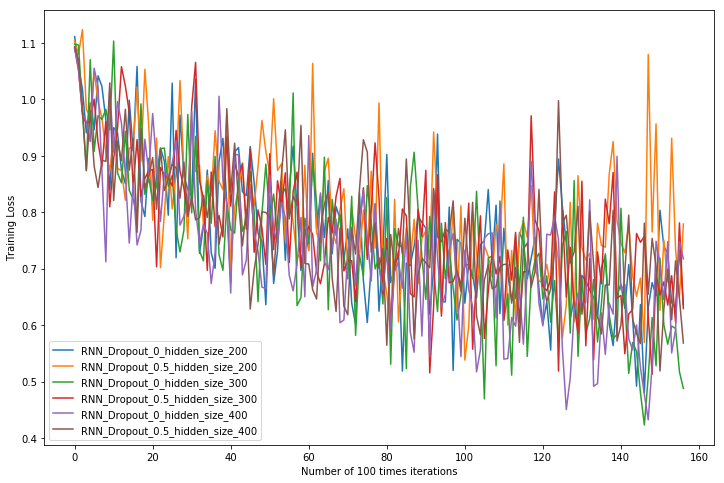

In [2]:
import pickle as pk
import matplotlib.pyplot as plt
%matplotlib inline


hidden_size_list = [200, 300, 400]
dropout_list = [0, 0.5]

plt.figure(figsize=(12,8))
plt.xlabel("Number of 100 times iterations")
plt.ylabel("Training Loss")

for hidden_size in hidden_size_list:
    for dropout_rate in dropout_list:
        filename= "RNN_Dropout_{}_hidden_size_{}".format(dropout_rate, hidden_size)
        with open('./Loss/'+filename+".p", "rb") as input:
            train_loss=pk.load(input)
        train_loss=[train_loss[i] for i in range (0, len(train_loss), 100)]
        plt.plot(train_loss, label=filename)
plt.legend(loc='best')
plt.show()

## RNN-Training Accuracy

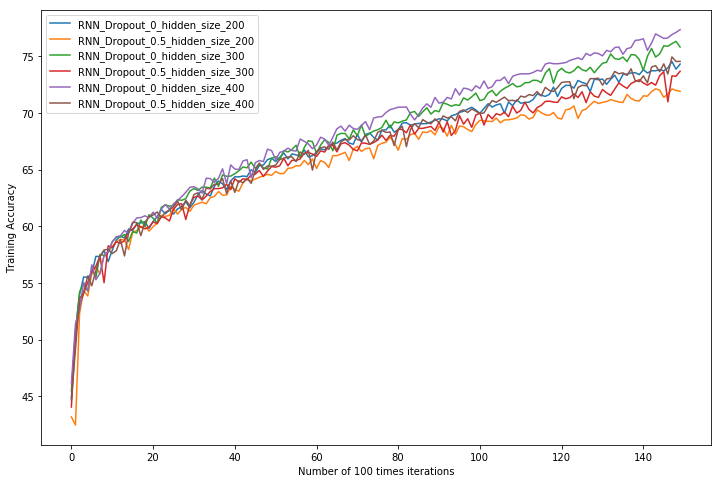

In [26]:
import pickle as pk
hidden_size_list = [200, 300, 400]
dropout_list = [0, 0.5]

plt.figure(figsize=(12,8))
plt.xlabel("Number of 100 times iterations")
plt.ylabel("Training Accuracy")

for hidden_size in hidden_size_list:
    for dropout_rate in dropout_list:
        filename= "RNN_Dropout_{}_hidden_size_{}".format(dropout_rate, hidden_size)
        with open('./train_acc/'+filename+".p", "rb") as input:
            train_acc=pk.load(input)     
        plt.plot(train_acc, label=filename)
plt.legend(loc='best')
plt.show()

## RNN-Validation Accuracy

200 0 67.7
200 0.5 68.6
300 0 68.6
300 0.5 67.1
400 0 68.6
400 0.5 68.6


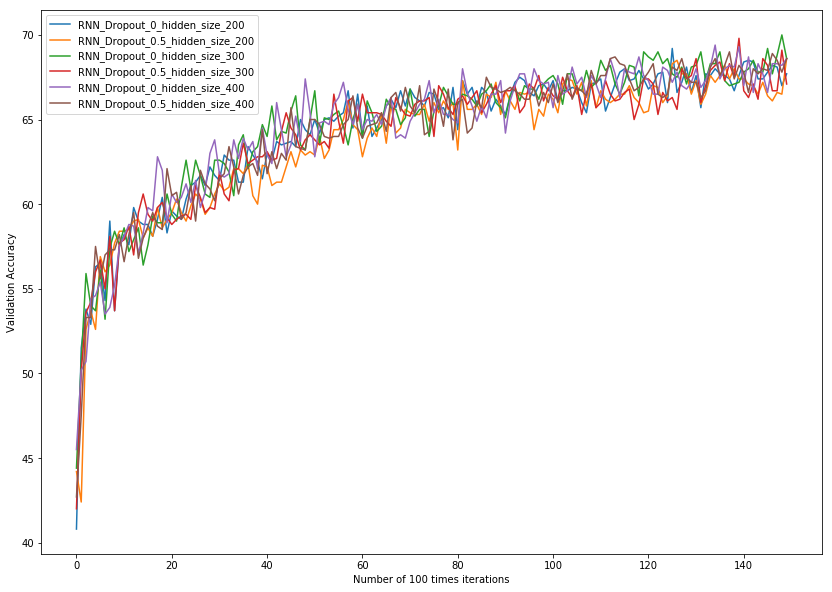

In [39]:
import pickle as pk
hidden_size_list = [200,300, 400]
dropout_list = [0, 0.5]

plt.figure(figsize=(14,10))
plt.xlabel("Number of 100 times iterations")
plt.ylabel("Validation Accuracy")

for hidden_size in hidden_size_list:
    for dropout_rate in dropout_list:
            
            
        filename= "RNN_Dropout_{}_hidden_size_{}".format(dropout_rate, hidden_size)
        with open('./val_acc/'+filename+".p", "rb") as input:
            val_acc=pk.load(input)     
        print (hidden_size, dropout_rate, val_acc[-1])
        plt.plot(val_acc, label=filename)
plt.legend(loc='best')
plt.show()

## CNN-Training Loss

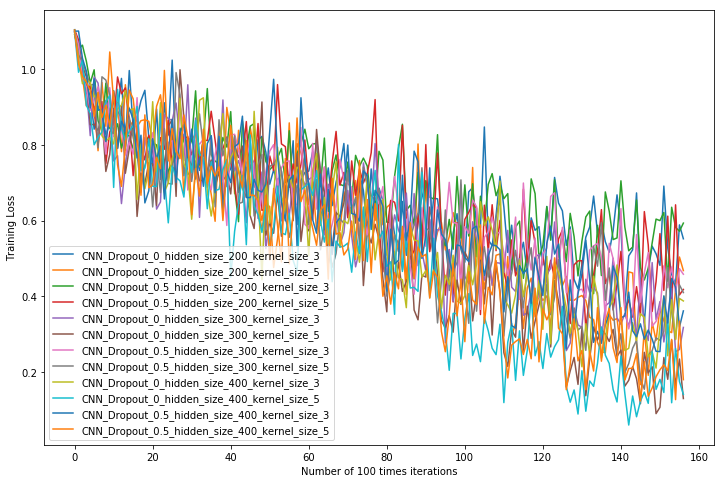

In [5]:
import pickle as pk
import matplotlib.pyplot as plt
%matplotlib inline


hidden_size_list = [200, 300, 400]
dropout_list = [0, 0.5]
kernel_size_list = [3, 5]

plt.figure(figsize=(12,8))
plt.xlabel("Number of 100 times iterations")
plt.ylabel("Training Loss")

for hidden_size in hidden_size_list:
    for dropout_rate in dropout_list:
        for kernel_size in kernel_size_list:
            filename= "CNN_Dropout_{}_hidden_size_{}_kernel_size_{}".format(dropout_rate, hidden_size, kernel_size)
            with open('./Loss/'+filename+".p", "rb") as input:
                train_loss=pk.load(input)
            train_loss=[train_loss[i] for i in range (0, len(train_loss), 100)]
            plt.plot(train_loss, label=filename)
plt.legend(loc='best')
plt.show()

## CNN-Training Accuracy

200 0 85.285
200 0 91.736
200 0.5 83.453
200 0.5 88.614
300 0 90.903
300 0 95.173
300 0.5 87.524
300 0.5 93.087
400 0 92.541
400 0 95.945
400 0.5 90.723
400 0.5 94.991


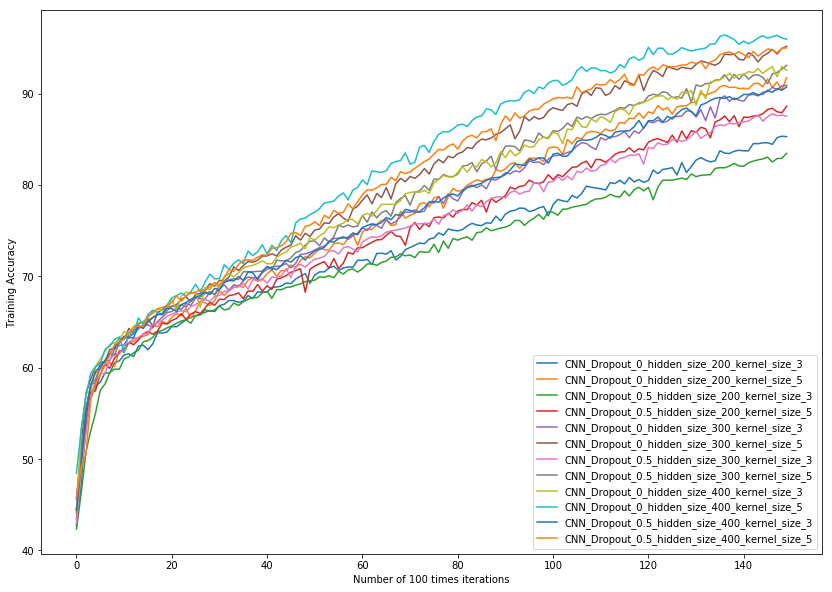

In [4]:
import pickle as pk
import matplotlib.pyplot as plt
%matplotlib inline

hidden_size_list = [200, 300, 400]
dropout_list = [0, 0.5]
kernel_size_list = [3, 5]

plt.figure(figsize=(14,10))
plt.xlabel("Number of 100 times iterations")
plt.ylabel("Training Accuracy")

for hidden_size in hidden_size_list:
    for dropout_rate in dropout_list:
        for kernel_size in kernel_size_list:
            
            filename= "CNN_Dropout_{}_hidden_size_{}_kernel_size_{}".format(dropout_rate, hidden_size, kernel_size)
            with open('./train_acc/'+filename+".p", "rb") as input:
                val_acc=pk.load(input)     
            print (hidden_size, dropout_rate, val_acc[-1])
            plt.plot(val_acc, label=filename)
plt.legend(loc='best')
plt.show()

## CNN-Validation Accuracy

200 0 3 63.9
200 0 5 65.8
200 0.5 3 66.0
200 0.5 5 63.4
300 0 3 67.6
300 0 5 65.2
300 0.5 3 65.8
300 0.5 5 64.1
400 0 3 64.8
400 0 5 62.1
400 0.5 3 65.6
400 0.5 5 63.8


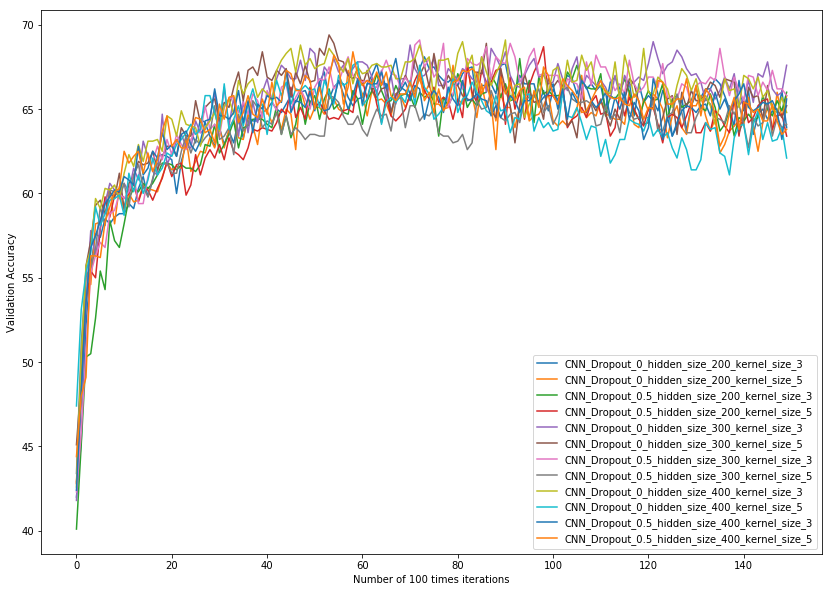

In [28]:
import pickle as pk
import matplotlib.pyplot as plt
%matplotlib inline

hidden_size_list = [200, 300, 400]
dropout_list = [0, 0.5]
kernel_size_list = [3, 5]

plt.figure(figsize=(14,10))
plt.xlabel("Number of 100 times iterations")
plt.ylabel("Validation Accuracy")

for hidden_size in hidden_size_list:
    for dropout_rate in dropout_list:
        for kernel_size in kernel_size_list:
            
            filename= "CNN_Dropout_{}_hidden_size_{}_kernel_size_{}".format(dropout_rate, hidden_size, kernel_size)
            with open('./val_acc/'+filename+".p", "rb") as input:
                val_acc=pk.load(input)     
            print (hidden_size, dropout_rate, kernel_size, val_acc[-1])
            plt.plot(val_acc, label=filename)
plt.legend(loc='best')
plt.show()

## Evaluation on MNLI dataset

In [7]:
import pickle as pkl
processed_mnli_data_val = pkl.load(open("./data/processed_mnli_data_val.p", "rb"))

In [8]:
Genres = ["fiction", "telephone", "slate", "government", "travel"]

In [30]:
# Build train, valid and test dataloaders
import numpy as np
import torch
# MAX_WORD_LENGTH_1=int (np.percentile([len(instance[0]) for instance in processed_snli_data_train], 99))
# MAX_WORD_LENGTH_2=int (np.percentile([len(instance[1]) for instance in processed_snli_data_val], 99))

BATCH_SIZE = 64

for genre in Genres:
    
    print ("genre:"+genre)
    val_dataset = SNLI_Dataset(processed_mnli_data_val[genre])
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                               batch_size=BATCH_SIZE,
                                               collate_fn=SNLI_collate_func,
                                               shuffle=True)
    
    filename= "RNN_Dropout_{}_hidden_size_{}".format(0, 300)
    trained_model= RNN(loaded_embeddings_ft=loaded_embeddings_ft, emb_size=300, hidden_size=300, drop_out_rate=0, num_layers=1, num_classes=3)
    trained_model.load_state_dict(torch.load('./model_trained/'+filename+".pt")) 
    print ("(best RNN)", test_model(val_loader, trained_model))
    
    filename= "CNN_Dropout_{}_hidden_size_{}_kernel_size_{}".format(0, 300, 3)
    trained_model= model = CNN(loaded_embeddings_ft=loaded_embeddings_ft, emb_size=300, hidden_size=300, dropout_rate=0, kernel_size=3, num_layers=2, num_classes=3)
    trained_model.load_state_dict(torch.load('./model_trained/'+filename+".pt")) 
    print ("(best CNN)", test_model(val_loader, trained_model))

genre:fiction
(best RNN) 47.537688442211056
(best CNN) 44.92462311557789
genre:telephone
(best RNN) 44.875621890547265
(best CNN) 42.885572139303484
genre:slate
(best RNN) 41.11776447105788
(best CNN) 40.31936127744511
genre:government
(best RNN) 45.17716535433071
(best CNN) 44.881889763779526
genre:travel
(best RNN) 44.39918533604888
(best CNN) 42.871690427698574


# Examples

In [40]:
filename= "CNN_Dropout_{}_hidden_size_{}_kernel_size_{}".format(0, 300, 3)
Best_model= model = CNN(loaded_embeddings_ft=loaded_embeddings_ft, emb_size=300, hidden_size=300, dropout_rate=0, kernel_size=3, num_layers=2, num_classes=3)
Best_model.load_state_dict(torch.load('./model_trained/'+filename+".pt"))     

In [59]:
import torch.nn.functional as F 
def example_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    predict_result=[]
    
    for sentence_1, length_1, sentence_2, length_2, labels in loader:
        
        sentence_1_batch, length_1_batch, sentence_2_batch, length_2_batch, labels =\
        sentence_1.to(device), length_1.to(device), sentence_2.to(device), length_2.to(device), labels.to(device)
        
        outputs = F.softmax(model(sentence_1_batch, length_1_batch, sentence_2_batch, length_2_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        
        predict_result=np.array(predicted.eq(labels.view_as(predicted)))
    return predicted, predict_result

In [60]:
predicted, predict_result=example_model(val_loader, Best_model)

In [44]:
correct = np.argwhere(predict_result==1)[:,0]
wrong = np.argwhere(predict_result==0)[:,0]

In [65]:
import pandas as pd
snli_data_val = pd.read_csv("./raw_data/snli_val.tsv", sep = '\t')

print('Correct Prediction:')
for i in correct[:3]:
    print('Premise: ', snli_data_val.iloc[i]['sentence1'])
    print('Hypothesis: ', snli_data_val.iloc[i]['sentence2'])
    print('label: ', snli_data_val.iloc[i]['label'])
    print('\n')

print('Wrong Prediction:')
for i in wrong[0:3]: #wrong[1] is too long
    pred_label_num = predicted[i]
    
    if pred_label_num == 0: pred_label = 'contradiction'
    elif pred_label_num == 1: pred_label = 'entailment'
    else: pred_label = 'netural'
        
    print('Premise: ', snli_data_val.iloc[i]['sentence1'])
    print('Hypothesis: ', snli_data_val.iloc[i]['sentence2'])
    print('true label: ', snli_data_val.iloc[i]['label'])
    
    print('predicted label: ', pred_label)
    print('\n')

Correct Prediction:
Premise:  Three women on a stage , one wearing red shoes , black pants , and a gray shirt is sitting on a prop , another is sitting on the floor , and the third wearing a black shirt and pants is standing , as a gentleman in the back tunes an instrument .
Hypothesis:  There are two women standing on the stage
label:  contradiction


Premise:  Four people sit on a subway two read books , one looks at a cellphone and is wearing knee high boots .
Hypothesis:  Multiple people are on a subway together , with each of them doing their own thing .
label:  entailment


Premise:  Man in overalls with two horses .
Hypothesis:  a man in overalls with two horses
label:  entailment


Wrong Prediction:
Premise:  bicycles stationed while a group of people socialize .
Hypothesis:  People get together near a stand of bicycles .
true label:  entailment
predicted label:  netural


Premise:  A group of numbered participants walk down the street together .
Hypothesis:  Participants wait 